# **Mounting Google Drive**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

{}

# **Uploading CSV for fetching of DOB, File Location, and Gender Data**

In [0]:
#Data Generation
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
import pandas as pd
df=pd.read_csv("wiki_1.csv")
df=df[0:1000]
df['photo_taken.1']=pd.to_datetime(df['photo_taken.1'])
df['dob']=pd.to_datetime(df['dob'])
df['age']=(df['photo_taken.1']-df['dob']).astype('<m8[Y]')


# **Fetching of Image pixel and resizing to size of 224,224,3**

In [0]:
import tensorflow as tf
target_size = (224, 224)
def getImagePixels(image_path):
  #Used Try Cath as few of to images are missing which could cause error
    try:
      img = tf.keras.preprocessing.image.load_img("drive/My Drive/data_wiki/wiki_crop/%s" % image_path, grayscale=False, target_size=target_size)
      x = tf.keras.preprocessing.image.img_to_array(img)
    # np.save(f, np.array(x))
      return x
    except Exception as e:
      return None

#Generate Pixels of Image
df['pixels'] = df['full_path'].apply(getImagePixels)

# Data Cleaning

In [0]:
#Create a new Data Frame having columns of Gender, Calculated Age and Pixels
df2=pd.DataFrame({'gender':df['gender'],'age':df['age'],'pixels':df['pixels']})
df2=df2.dropna()#Drop rows with blank cell value
Y=pd.DataFrame()
Y=pd.concat([Y,df2['gender'],df2['age']],axis=1).to_numpy()#Generate Output

import numpy as np
X=np.array(df2['pixels'])
X=np.stack(X,axis=0)

# Create One hot encoding for Age values
temp=np.zeros((Y.shape[0],101))
for j in range(Y.shape[0]):
  # temp[j][0]=Y_temp[j][0]
  temp[j][min(int(Y[j][1]),100)]=1


# Y=np.delete(Y,[0,0],axis=1)
Y=temp
#Save Image to Google Drive
np.save('drive/My Drive/wiki_data/X_final.npy', X)#Saving of X as numpy array in drive
np.save('drive/My Drive/wiki_data/Y_final.npy',Y)#Saving of Y as numpy array in drive



# Skip the above cleaning from now onwards and fetch pickled numpy values from drive

In [0]:
import numpy as np

X=np.load('drive/My Drive/Data/X_final.npy')
Y=np.load('drive/My Drive/Data/Y_final.npy')

### **VGG Face Transfer Learning**

In [2]:
from keras.models import Sequential
from keras.layers import Input, Add, Dense,Dropout,Convolution2D, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='tanh'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='tanh'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='tanh'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='tanh'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='tanh'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='tanh'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
# model.add(Flatten())
# model.add(Activation('softmax'))
model.add(Dropout(0.5))
model.add(Convolution2D(1311, (1, 1)))
model.add(Dropout(0.5))
model.add(Convolution2D(655, (1, 1)))
model.add(Convolution2D(100, (1, 1), name='predictions'))
model.add(Flatten())
model.add(Activation('softmax'))
 
# age_model = Model(inputs=model.input)
# Load Pretrained model for above architecture
model.load_weights('drive/My Drive/Data/vgg_face_weights.h5')

for layer in model.layers[:-7]:
  layer.trainable = False

#Create on top layer for training again for last 7 Layers and the below new layers 
base_model_output = Sequential()
base_model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)


Using TensorFlow backend.


In [0]:
age_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0   

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='age_model_weights_vgg_transfer.h5'
, monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')
 

Train, Test, Validation Set

In [0]:
# X=X/255 #Normalize Input
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)
X_train,X_val,y_train, y_val=train_test_split(X_train,y_train,test_size=0.15, random_state=0)


In [0]:
#Make X and Y as None to reduce load on RAM
X=None
Y=None

In [0]:
#I have saved the above numpy array as individual in drive
import numpy as np
X_train=np.load('drive/My Drive/wiki_data/X_train_verified.npy')
X_test=np.load('drive/My Drive/wiki_data/X_test_verified.npy')
X_val=np.load('drive/My Drive/wiki_data/X_val_verified.npy')
y_train=np.load('drive/My Drive/wiki_data/Y_train_verified.npy')
y_test=np.load('drive/My Drive/wiki_data/Y_test_verified.npy')
y_val=np.load('drive/My Drive/wiki_data/Y_val_verified.npy')

In [0]:
# Normalize data
X_train=X_train/255
X_test=X_test/255
X_val=X_val/255

In [6]:
#For age detection remove the top most value of Y which represents gender
y_val=np.delete(y_val,[0,0],axis=1)
y_train=np.delete(y_train,[0,0],axis=1)
y_test=np.delete(y_test,[0,0],axis=1)
print(y_val.shape,y_train.shape,y_test.shape)

(1314, 100) (7440, 100) (4714, 100)


In [0]:

from keras.optimizers import SGD

age_model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

age_model.fit(X_train, y_train, epochs = 200, batch_size = 64,validation_data=(X_val, y_val), callbacks=[checkpointer])


In [0]:
pred=model.evaluate(X_test,y_test)
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

4714/4714 [==============================] - 18s 4ms/step
Loss = 4.056853311164024
Test Accuracy = 0.04645736142992973


# Predicted Age

In [0]:
np.sum(model.predict(X_test[3].reshape(1,224,224,3))*np.arange(1,101))

38.91218397999182

# RESNET50

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [0]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X =  Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)


    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X =  Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='age_model_resnet50_1.hdf5'
, monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')
 

In [0]:
model = ResNet50(input_shape = (224, 224, 3), classes = 100)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.25, random_state=42)

In [0]:
X_train,X_val,y_train, y_val=train_test_split(X_train,y_train,test_size=0.15, random_state=0)

In [0]:
X=None
Y=None

In [0]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32,validation_data=(X_val, y_val), callbacks=[checkpointer])


Train on 8585 samples, validate on 1516 samples
Epoch 1/100
8585/8585 [==============================] - 105s 12ms/step - loss: 6.3559 - accuracy: 0.0366 - val_loss: 4.0118 - val_accuracy: 0.0475

Epoch 00001: val_loss improved from inf to 4.01179, saving model to age_model_resnet50_1.hdf5
Epoch 2/100
8585/8585 [==============================] - 88s 10ms/step - loss: 4.0197 - accuracy: 0.0441 - val_loss: 3.9686 - val_accuracy: 0.0508

Epoch 00002: val_loss improved from 4.01179 to 3.96860, saving model to age_model_resnet50_1.hdf5
Epoch 3/100
8585/8585 [==============================] - 88s 10ms/step - loss: 3.9610 - accuracy: 0.0454 - val_loss: 3.9569 - val_accuracy: 0.0475

Epoch 00003: val_loss improved from 3.96860 to 3.95690, saving model to age_model_resnet50_1.hdf5
Epoch 4/100
8585/8585 [==============================] - 89s 10ms/step - loss: 3.8950 - accuracy: 0.0540 - val_loss: 3.9455 - val_accuracy: 0.0515

Epoch 00004: val_loss improved from 3.95690 to 3.94549, saving model 

In [0]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [0]:
model.save_weights('age_model_resnet50.hdf5')


# KERAS VGGFACE

In [0]:
!pip install keras_vggface

In [0]:

# Example of face detection with a vggface2 model
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

Using TensorFlow backend.


In [0]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

94699520/94694792 [==============================] - 2s 0us/step


In [0]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
from keras.models import Sequential
from keras.layers import Input, Add, Dense,Dropout, Convolution2D,Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Dense
from keras.regularizers import l2
...

classes=101
for layer in model.layers[:-10]:
  layer.trainable = False
 
base_model_output = Sequential()
# base_model_output = Convolution2D(100, (1, 1), name='predictions')(model.layers[-3].output)
# base_model_output=Dropout(0.3, input_shape=(2048,))(model.layers[-1].output)
# base_model_output=Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model.layers[-1].output)

base_model_output = Flatten()(base_model_output)
# base_model_output = Activation('softmax')(base_model_output)
base_model_output = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

In [0]:
age_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [0]:
# X=X/255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train,X_val,y_train, y_val=train_test_split(X_train,y_train,test_size=0.15, random_state=0)
y_val=np.delete(y_val,[0,0],axis=1)
print(y_val.shape)

In [0]:
X=None
Y=None

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='age_model_vgg19_facenet.hdf5'
, monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')
 

In [0]:
from keras.optimizers import SGD
age_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
age_model.fit(X_train, y_train, epochs = 100, batch_size = 64,validation_data=(X_val, y_val), callbacks=[checkpointer])


Train on 9729 samples, validate on 1718 samples
Epoch 1/100
9729/9729 [==============================] - 111s 11ms/step - loss: 4.1182 - accuracy: 0.0410 - val_loss: 4.0401 - val_accuracy: 0.0355

Epoch 00001: val_loss improved from 844.78237 to 4.04014, saving model to age_model_vgg19_facenet.hdf5
Epoch 2/100
9729/9729 [==============================] - 112s 11ms/step - loss: 4.0446 - accuracy: 0.0425 - val_loss: 4.0427 - val_accuracy: 0.0466

Epoch 00002: val_loss did not improve from 4.04014
Epoch 3/100
9729/9729 [==============================] - 110s 11ms/step - loss: 4.0394 - accuracy: 0.0415 - val_loss: 4.0408 - val_accuracy: 0.0454

Epoch 00003: val_loss did not improve from 4.04014
Epoch 4/100
9729/9729 [==============================] - 110s 11ms/step - loss: 4.0395 - accuracy: 0.0409 - val_loss: 4.0367 - val_accuracy: 0.0396

Epoch 00004: val_loss improved from 4.04014 to 4.03666, saving model to age_model_vgg19_facenet.hdf5
Epoch 5/100
9729/9729 [===========================

# Inception V3

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import load_model

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))  # this assumes K.image_data_format() == 'channels_last'
# model = load_model('facenet_weights.h5')
# model.summary()
model = InceptionV3(input_tensor=input_tensor, include_top=False)

Using TensorFlow backend.


87916544/87910968 [==============================] - 2s 0us/step


In [0]:

temp=np.zeros((101)

for i in range(1,100):
  temp[i]=i


In [0]:

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(100, (1, 1), name='predictions'))
model.add(Flatten())
model.add(Activation('softmax'))
 
age_model=model

# Gender Prediction

In [0]:
#Generate 2 class of Age. One hot encoding & 
temp=np.zeros((Y.shape[0],101))
for j in range(Y.shape[0]):
  # temp[j][0]=Y_temp[j][0]
  temp[j][min(int(Y[j][1]),100)]=1


# Y=np.delete(Y,[0,0],axis=1)
Y=temp

In [0]:
from keras.models import Sequential
from keras.layers import Input, Add, Dense,Dropout,Convolution2D, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


model.load_weights('drive/My Drive/Data/vgg_face_weights.h5')




In [0]:
for layer in model.layers[:-7]:
  layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(2, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
gender_model = Model(inputs=model.input, outputs=base_model_output)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='drive/My Drive/Data/gender_model_weights_vgg_transfer.h5'
, monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')
 

In [0]:
X=X/255 #Normalize Input
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train,X_val,y_train, y_val=train_test_split(X_train,y_train,test_size=0.15, random_state=0)
y_val=np.delete(y_val,[0,0],axis=1)
print(y_val.shape)


In [0]:
from keras.optimizers import SGD

gender_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

gender_model.fit(X_train, y_train, epochs = 100, batch_size = 64,validation_data=(X_val, y_val), callbacks=[checkpointer])


In [0]:
gender_model.load_weights('drive/My Drive/Data/gender_model_weights_vgg_transfer.h5')

In [0]:
from google.colab import files
files.upload()

Saving Profile.jpg to Profile.jpg


{'Profile.jpg': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xdc\x00\x00\x01\xa0\x08\x06\x00\x00\x00\x00C\xd6O\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x01YiTXtXML:com.adobe.xmp\x00\x00\x00\x00\x00<x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="XMP Core 5.4.0">\n   <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">\n      <rdf:Description rdf:about=""\n            xmlns:tiff="http://ns.adobe.com/tiff/1.0/">\n         <tiff:Orientation>1</tiff:Orientation>\n      </rdf:Description>\n   </rdf:RDF>\n</x:xmpmeta>\nL\xc2\'Y\x00\x00@\x00IDATx\x01\xec\xbd\xe9\x92\x1d9\x96\xadwb\xe4\xcc\xccd2\xa7\x1a\xba\xfb\xf65\xc9Zv\x1fV/ \xd3/=\x86~\xea!t\xeb\xb6\xba\xaa\xbb\xabr"\x93s\x04\x19\xb3\xd6\xb76\x96;\xdc\xc3O\xc4\t\x92\x99\x95ivAz\x00\xd8\xd8\x136\xe0\xd8\x00\x1c\xeeg\xeb\xff\xfe?\xff\x8f\x8b\xad\xad\xadU\xc2\xf6\xf6\xf6\x8a\xfc\xd6\xf6\xaab\xd2]y\xf0\x02sl\x1c\x11\xb4\x90\xb2\xe4\x89\x97`}\xf9<\x1d\xfc\xeb\xe2\x91\xf7\xc5\xa0\xef\x9c\xd7R\xfe\xbcU9\xfc\x97pF\xdeNMP...&y2

In [0]:
!pip install MTCNN

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [0]:
from mtcnn.mtcnn import MTCNN

In [0]:
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img('28-Male.jpg', grayscale=False, target_size=(224,224,3))
x = tf.keras.preprocessing.image.img_to_array(img)
x=x.reshape(1,224,224,3)

# detector = MTCNN()
# # detect faces in the image
# faces = detector.detect_faces(x)

In [0]:
gender=gender_model.predict(x.reshape(1,224,224,3))

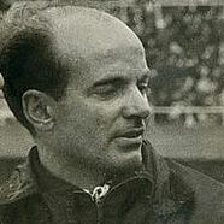

In [0]:
img

In [0]:
gender

array([[0.4812561 , 0.51874393]], dtype=float32)

In [0]:
gender_model.evaluate(X_test, y_test, verbose=1)